In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import random

In [13]:
path_saves = Path('./../saves/ratings')
path_listener_info = Path('./../saves/ratings/listener_info.csv')
nat_ref_min = 0.6  # minimum score for ref for it to be classed as success
avg_nat_ref_min = 0.6  # average success score for person's results to be used

In [14]:
def question_bank(question):
    if question[:3] == 'sim':
        return '-'
    elif question[:3] == 'nat':
        return question[4]
    return 'Error'


def load_results_df(path_saves, path_listener_info, nat_ref_min):
    df_results = pd.DataFrame()
    df_info = load_listener_info(path_listener_info)
    

    # read all csv results files and create dataframe
    for filename in os.listdir(path_saves):
        if filename.endswith(".csv") and filename[3] == '-':
            path_file = path_saves / filename
            
            df_file = pd.read_csv(path_file)
            df_file = df_file.melt(id_vars=['file_keys'])
            
            df_results = pd.concat([df_results, df_file], ignore_index=True)
            

    # rename columns and unpivot to have each row with a single question answer
    df_results.rename(columns={'variable':'question'}, inplace=True)

    # add info about question. Model, and what question bank it came from, eg. t=tricky, a=alexia (only for nat)
    df_results['question_type'] = df_results['question'].str[:3]
    df_results['model'] = df_results.question.str[-3:]
    is_nat = df_results['question_type'] == 'nat'
    df_results['question_bank'] = df_results.question.apply(question_bank)
    df_results['ref_above_min'] = df_results['value'].apply(lambda x: True if x > nat_ref_min else False)
    df_results = df_results.merge(df_info, on='file_keys', how='left')
    return df_results


def load_listener_info(path_info):
    df_info = pd.read_csv(path_info)
    return df_info
    


def get_natural_passed(df_results, avg_nat_ref_min, is_headphones=False, english_min=0.25, is_quiet=False):
    # Return a list of unique ids (file_keys) that scored the natural reference high enough consistently
    df_results_nat_ref = df_results[(df_results['question_type'] == 'nat') * (df_results['model']=='ref')]
    avg_nat_ref = df_results_nat_ref.groupby('file_keys')['ref_above_min'].mean()

    nat_passed = avg_nat_ref[avg_nat_ref > avg_nat_ref_min].index
    print(f'nat_ref_min: {len(nat_passed)}')
    
    if is_headphones:
        nat_headphones = df_results[(df_results.headphones == 1) * (df_results['question_type'] == 'nat')].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_headphones)]
        print(f'headphones: {len(nat_headphones.unique())}')
    if is_quiet:
        nat_quiet = df_results[(df_results.quiet == 1) * (df_results['question_type'] == 'nat')].file_keys
        nat_passed = nat_passed[nat_passed.isin(nat_quiet)]
        print(f'quiet: {len(nat_quiet.unique())}')
    
    nat_english_min = df_results[(df_results['question_type']=='nat') * (df_results['english']>english_min)].file_keys
    nat_english_min = nat_english_min.unique()
    print(f'english_min: {len(nat_english_min)}')
    nat_passed = nat_passed[nat_passed.isin(nat_english_min)]
    
    return nat_passed


def get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=False, is_quiet=False, english_min=0.25):
    # get list of ids that passed
    nat_passed = get_natural_passed(df_results, avg_nat_ref_min, is_headphones=is_headphones, is_quiet=is_quiet, english_min=english_min)
    print(f'{len(nat_passed)} participants passed naturalness')
    # given results and ids of who passed, return a dictionary of scores for each model
    results_nat = {'ref': None, 'mel': None, 'v08': None, 'v09': None, 'v10': None}
    nat_models = ['ref', 'mel', 'v08', 'v09', 'v10']

    for model in nat_models:
        results_nat[model] = np.array(df_results[(df_results['question_type'] == 'nat') * (df_results['model'] == model) * (df_results['file_keys'].isin(nat_passed))].value.tolist())
    
    return results_nat  # dictionary of results


def get_sim_processed_results(df_results):
    results_sim = {'ref': None, 'mel': None, 'v09': None}
    sim_models = ['ref', 'mel', 'v09']

    for model in sim_models:
        results_sim[model] = np.array(df_results[(df_results['question_type'] == 'sim') * (df_results['model'] == model)].value.tolist())
    return results_sim  #dictionary of results


def bootstrap_results(results_type, nb_bootstrap=5000):
    # given a dictionary of results and the number of times to iterate bootstrap, calculate the mean and confidence intervals
    results_mean = {}

    # get the list of results for a specific model, eg. mel
    for model in results_type:
        results = results_type[model]
        N = len(results)
        results_mean[model] = {}
        # calculate the given mean from the original sample
        results_mean[model]['mean'] = results.mean()    
        
        # now repeat bootstrap and calculate distribution of means
        mean_list = []
        for n in range(int(nb_bootstrap)):
            random_sample = np.random.choice(results, size=N, replace=True)
            mean_list.append(random_sample.mean())
        mean_list.sort()
        
        # get the 95% confidence intervals
        lower_index = int(0.025 * nb_bootstrap)
        upper_index = int(0.975 * nb_bootstrap)
        results_mean[model]['lower'] = mean_list[lower_index]
        results_mean[model]['upper'] = mean_list[upper_index]
        
    return results_mean  # dictionary of mean, and CI for each model


def print_results_mean(results_mean, question_type):
    print(f'*****************')
    print(f'{question_type:17}')
    print(f'*****************')
    for model in results_mean:
        mean = results_mean[model]['mean']
        lower = results_mean[model]['lower']
        upper = results_mean[model]['upper']
        print(f'{model}:\n    mean: {mean:0.3f}\n    CI: [{lower:0.3f}, {upper:0.3f}]\n')

In [15]:
df_results = load_results_df(path_saves, path_listener_info, nat_ref_min)
results_nat = get_nat_processed_results(df_results, avg_nat_ref_min, is_headphones=True, is_quiet=True)
results_sim = get_sim_processed_results(df_results)
nat_results_mean = bootstrap_results(results_nat)
sim_results_mean = bootstrap_results(results_sim)

print_results_mean(nat_results_mean, 'Naturalness')
print_results_mean(sim_results_mean, 'Similarity')

nat_ref_min: 29
headphones: 26
quiet: 46
english_min: 48
15 participants passed naturalness
*****************
Naturalness      
*****************
ref:
    mean: 0.730
    CI: [0.686, 0.770]

mel:
    mean: 0.600
    CI: [0.562, 0.638]

v08:
    mean: 0.424
    CI: [0.387, 0.462]

v09:
    mean: 0.585
    CI: [0.550, 0.622]

v10:
    mean: 0.564
    CI: [0.526, 0.601]

*****************
Similarity       
*****************
ref:
    mean: 0.610
    CI: [0.581, 0.640]

mel:
    mean: 0.663
    CI: [0.637, 0.689]

v09:
    mean: 0.596
    CI: [0.569, 0.624]



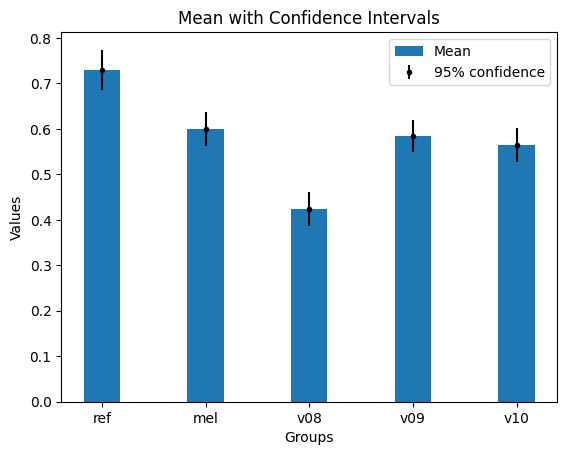

In [16]:
import matplotlib.pyplot as plt

# Sample data
means = []
lower_bounds = []
upper_bounds = []
for model in nat_results_mean:
    means.append(nat_results_mean[model]['mean'])
    lower_bounds.append(nat_results_mean[model]['lower'])
    upper_bounds.append(nat_results_mean[model]['upper'])

# Create a figure and axis
fig, ax = plt.subplots()

bar_width = 0.35

# Plot means with error bars (confidence intervals)
ax.bar(nat_results_mean.keys(), means, bar_width, label='Mean')
ax.errorbar(nat_results_mean.keys(), means, yerr=[means[i] - lower_bounds[i] for i in range(len(means))], fmt='.', label='95% confidence', color='black')


# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Groups')
ax.set_ylabel('Values')
ax.set_title('Mean with Confidence Intervals')

# Show the plot
plt.show()

In [19]:
a = df_results[df_results['question_type']=='nat'].sort_values(by='name')
# a = a[a['model']=='ref']
 # ['Emily Delve' 'Eleanor Poole' 'Daniel Gosden']
 # ['Jake Egbers' 'Franck Barga' 'Hanson ' 'Emily Delve' 'George' 'Mike Jones' 'Tom Emberson' 'Ross']
a = a[(a['name'] == 'test') * (a['value'] > 0.9)]
a[['name', 'question', 'model', 'headphones', 'quiet', 'value']]

,name,question,model,headphones,quiet,value
3607,test,nat-t-13-mel,mel,1,1,1.0
2255,test,nat-t-03-v09,v09,1,1,1.0
621,test,nat-a-05-ref,ref,1,1,1.0
3049,test,nat-a-04-v08,v08,1,1,1.0
1505,test,nat-t-05-mel,mel,1,1,1.0
3146,test,nat-a-14-v09,v09,1,1,1.0
1168,test,nat-t-14-v10,v10,1,1,1.0
295,test,nat-t-04-v08,v08,1,1,1.0
2867,test,nat-a-12-mel,mel,1,1,1.0
2932,test,nat-a-13-mel,mel,1,1,1.0
